Import the libraries

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pgmpy as pg
import tabulate as tb
import numpy as np
import sklearn
from IPython.core.display import display, HTML

Task 1: To design and implement the solution to crawl all unique publication
titles (i.e. the title of the paper) with the corresponding “Citation” numbers, for those publications that have citations. Please then sort the list according to the descending “Citation” number. 

Expected output: To present the title and citation number of the top 25 cited papers with a table.

In [2]:
url = "" # url of the main page
page = requests.get(url) # Get the url of the main page 
soup = BeautifulSoup(page.content, "html.parser") # Extract the content of the main page's html
urlMain = soup.find('div', class_ = "navigator") # Find the navigators (home, publications)
links = urlMain.find_all("a") ## Finds all the links from the main page
temp_url = links[1]["href"] ## Stores the link to the publications page from the main page
new_url = url[:len(url)-9]+temp_url ## Create a new link for publications page
page = requests.get(new_url) # Get the url of the publications page
soup = BeautifulSoup(page.content, "html.parser") # Extract the content of the publication page's html
divPublications = soup.find_all("p", class_="TextOption") # Find the div to all the links of the topics
divTopics = divPublications[1].find_all("a") # Find all the links for individual topics
urlTopics = [] # Create an empty list to append the urls of publications under each topic
for divTopic in divTopics: # Select each publication to add prefix to create urls
    urlTopics.append(url[:len(url)-9] + divTopic['href']) # Append the urls of individual topics in the empty list
urlTopics.append(new_url) # Append the original link of "character animation" topic in the list
urlPublications = [] # Create an empty list to append the urls of all the publications in each topic
for urlTopic in urlTopics: # Select individual topics link for each iteration
    page = requests.get(urlTopic) # Get the url of each topic's page 
    soup = BeautifulSoup(page.content, "html.parser") # Get the html content of each topic's page
    divPublications = soup.find_all("div", class_="ImgIconPublicationDiv") # Find the div where all the links for each publication under a topic is stored
    for divPublication in divPublications: # Iterate over all the html content
        aPublication = divPublication.find("a") # Find link to for each publication in the div
        if (aPublication != None): # Check if the link exists or not
            urlPublications.append(aPublication['href']) # If the link exists, append the list of each publication from all the topics in the empty list

urlAllPublications = [] # Create the list to store all the links with their prefix "https:...."
for urlPublication in urlPublications: # Select each link
    urlAllPublications.append(url[:len(url)-9] + urlPublication) # Create the urls for each publication with their prefixs
urlGlobalUniques = list(set(urlAllPublications)) # Create a list of unique links as some topics share some publications
citations = []  # Create empty list to append citations for each publication if they exist
titles = [] # Create empty list to append the name of the titles
data = [] # Create empty list to append both citations and titles
for i in urlGlobalUniques: # Select each unique link for publication to iterate over the loop
    tem_url = i # Store the url in a variable
    page = requests.get(tem_url) # Get the page using requests
    soup = BeautifulSoup(page.content, "html.parser") # Get the html content of the publication page
    divCitation = soup.find("div", id ="divBackground") # Find the outer div where the citation is stored
    if (divCitation != None): # Check if the citation exists or not
        citation = divCitation.find('div', {'style': "color:orange"}).text # Find the inner div where the citation text is stored
        citation_value = citation.split(':')[-1].strip().split('#')[0] # Use split to only extract the value of the citation
        if citation_value != "": # Check if the citation value is null
            citation_text = float(citation_value) # Convert the string to integer data type for citation
            citations.append(citation_text) # Append the list with the citation of the publication
            title = divCitation.find('h1').text # Find the div where the title of the publication is stored
            titles.append(title) # Append the list with the name of the title
            data.append({'Title': title, 'Citation': citation_text}) # Append the list with the citation and title of the publicaiton

            
df = pd.DataFrame(data) # Use pandas to create a dataframe using the data list
top_25 = df.sort_values(by='Citation', ascending=False, ignore_index = True).head(25) # Sort dataframe by citation number in descending order
top_25 # Display the dataframe for the top 25 publications based on their citations


,Title,Citation
0,A Quadruple Diffusion Convolutional Recurrent ...,228.0
1,Interaction Patches for Multi-Character Animation,201.0
2,Real-Time Posture Reconstruction for Microsoft...,150.0
3,Simulating Multiple Character Interactions wit...,112.0
4,Simulating Competitive Interactions using Sing...,112.0
5,Simulating Interactions of Avatars in High Dim...,102.0
6,Kinect Posture Reconstruction based on a Local...,98.0
7,Interaction-based Human Activity Comparison,88.0
8,Environment-aware Real-Time Crowd Control,79.0
9,Real-time Physical Modelling of Character Move...,68.0


Task 2: On each publication’s page of the target website, there is a list of items inside the section “Links, Downloads and Online Resources” (hereby known as the LDO items). Design and implement the solution to crawl necessary information.

Expected output: Generate a scatter chart that shows the average number of LDO items against the year of publication. Show the name and number of the LDO items of the top 25 publications according to the LDO items.

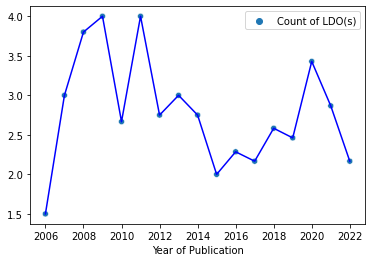

,Title,Count of LDO(s),Year of Publication
0,Interaction Patches for Multi-Character Animation,7,2008
1,DSPP: Deep Shape and Pose Priors of Humans,5,2019
2,Makeup Style Transfer on Low-quality Images wi...,5,2020
3,Foreground-aware Dense Depth Estimation for 36...,5,2020
4,Simulating Multiple Character Interactions wit...,5,2012
5,Simulating Interactions of Avatars in High Dim...,5,2008
6,Resolving Hand-Object Occlusion for Mixed Real...,5,2020
7,Single Sketch Image based 3D Car Shape Reconst...,4,2020
8,Interpreting Deep Learning based Cerebral Pals...,4,2021
9,Semantics-STGCNN: A Semantics-guided Spatial-T...,4,2021


In [3]:
## Used same program as previous question till returning all the links of the unique publications

url = ""
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
urlMain = soup.find('div', class_ = "navigator") 
links = urlMain.find_all("a") ## Finds all the links from the main page
temp_url = links[1]["href"] ## Stores the link to the publications page from the main page
new_url = url[:len(url)-9]+temp_url
page = requests.get(new_url)
soup = BeautifulSoup(page.content, "html.parser")
urlPublications = []
divPublications = soup.find_all("p", class_="TextOption")
divTopics = divPublications[1].find_all("a")
urlTopics = []
for divTopic in divTopics:
    urlTopics.append(url[:len(url)-9] + divTopic['href'])
urlTopics.append(new_url)

urlPublications = []
for urlTopic in urlTopics:
    page = requests.get(urlTopic)
    soup = BeautifulSoup(page.content, "html.parser")
    divPublications = soup.find_all("div", class_="ImgIconPublicationDiv")
    for divPublication in divPublications:
        aPublication = divPublication.find("a")
        if (aPublication != None):
            urlPublications.append(aPublication['href'])

urlAllPublications = []
for urlPublication in urlPublications:
    urlAllPublications.append(url[:len(url)-9] + urlPublication)
urlGlobalUniques = list(set(urlAllPublications))




## To find the list of LDOs per publication
len_LDO = [] ## Create an empty list to append and store the count of resources in every publication
for i in urlGlobalUniques: ## Take every publication link for each iteration
    tem_url = i ## Store the link in a temporary variable
    page = requests.get(tem_url) ## Get the html content of each publication
    soup = BeautifulSoup(page.content, "html.parser") # Extract the content of the publication's html
    divResources = soup.find_all('div', {'style': "margin-left: var(--size-marginleft)"}) ## This is the div and class where the command will return all the panels containing the LDOs 
    divOuter = divResources[1] ## Store the content of 2nd occurrence of the div
    if divOuter: ## Check if LDOs exist or not
        divLDO = divOuter.find_all('a', href = True) ## If LDOs exist, find all the links inside each publication
        count = [] ## Initiate a temporary counter to count the number of items 
        for a in divLDO: ## Select individual item from the resources
                count.append(a.text) ## Append all items in the empty list
                result = list(filter(lambda x: x != "", count)) ## Use lambda function to make a list of items in the publication and store in the variable "result"
                num_ldo = len(result) ## Count the number of items in the list
        len_LDO.append(num_ldo) ## Returns the number of LDOs per publication

        

        
        
## To find the year of the publication
year = [] ## Create an empty list to store the year of publication for each publication
for i in urlGlobalUniques:
    tem_url = i
    page = requests.get(tem_url)
    soup = BeautifulSoup(page.content, "html.parser")
    div1 = soup.find('div', {'style': "margin-left: var(--size-marginleft);text-align: center"}) ## This is the div and class where the command will return the year of the publication
    div2 = soup.find("h2") ## Find the text within the div to extract the string containing the year
    year.append(int(div2.text[-4:])) ## Only return the exact value of the year convert the string to an integer and append in the year list


    

## To find the title of the publication
titles = [] ## Create an empty list to store the title of the publications
for i in urlGlobalUniques:
    tem_url = i
    page = requests.get(tem_url)
    soup = BeautifulSoup(page.content, "html.parser")
    divTitle = soup.find('div', id= "divBackground") ## This is the div and class where the command will return the title of the publication
    title = divTitle.find('h1', {"style":"text-align: center"}).text ## Find the text within the div to extract the string containing the title
    titles.append(title) ## Append the title of the publication to the list


    
    

## Creating a dataframe
df2 = pd.DataFrame(list(zip(titles,len_LDO, year)), columns = ["Title","Count of LDO(s)", "Year of Publication"]) ## Use pandas and create a dataframe from the information scrapped
average_ldo_count = df2.groupby('Year of Publication').mean() ## Group the year of publication and return the mean of count of LDOs for the publications published that year
sns.scatterplot(data=average_ldo_count) ## PLot a scatterplot using the above information
plt.plot(average_ldo_count, color='blue')
plt.show() ## Command to display the plot




## Extracting Top 25 Publications according the the LDO items
top_25_publications = df2.sort_values(by='Count of LDO(s)', ascending=False,ignore_index=True).head(25)
top_25_publications

Task 3: On the target website, the publication page contains several features and attributes related to
the research articles published by several authors. Design and implement the solution to use
data analysis and visualization for the following tasks:

a. Sort the research topics related to the publications of the top ten 'highly cited' authors.
Analyse which authors collaborate (or appear) as co-authors in the publications based
on the research topics. Suggest the most popular topics where the authors collaborate
with each other. Justify and visualise your outcomes. 

b. Analyse the relationship between the features of the publication and the "citation"
count. Suggest the top three features that have the highest impact on the "citation"
count. Justify your answers with valid reasons.

c. Each publication is published in a specific type of venue (such as “journal” or
“conferernce”). You have to identify a specific feature "impact factor" for the
publications and analyse its relationship with the type of venue where the article has
been published.

Question 3A: Sort the research topics related to the publications of the top ten 'highly cited' authors. Analyse which authors collaborate (or appear) as co-authors in the publications based on the research topics. Suggest the most popular topics where the authors collaborate with each other. Justify and visualise your outcomes.

In [4]:
## Used same program as previous question till returning all the links of the unique publications

url = "" # url of the main page
page = requests.get(url) # Get the url of the main page 
soup = BeautifulSoup(page.content, "html.parser") # Extract the content of the main page's html
urlMain = soup.find('div', class_ = "navigator") # Find the navigators (home, publications)
links = urlMain.find_all("a") ## Finds all the links from the main page
temp_url = links[1]["href"] ## Stores the link to the publications page from the main page
new_url = url[:len(url)-9]+temp_url ## Create a new link for publications page
page = requests.get(new_url) # Get the url of the publications page
soup = BeautifulSoup(page.content, "html.parser") # Extract the content of the publication page's html
divPublications = soup.find_all("p", class_="TextOption") # Find the div to all the links of the topics
divTopics = divPublications[1].find_all("a") # Find all the links for individual topics
urlTopics = [] # Create an empty list to append the urls of publications under each topic
for divTopic in divTopics: # Select each publication to add prefix to create urls
    urlTopics.append(url[:len(url)-9] + divTopic['href']) # Append the urls of individual topics in the empty list
urlTopics.append(new_url) # Append the original link of "character animation" topic in the list
urlPublications = [] # Create an empty list to append the urls of all the publications in each topic
for urlTopic in urlTopics: # Select individual topics link for each iteration
    page = requests.get(urlTopic) # Get the url of each topic's page 
    soup = BeautifulSoup(page.content, "html.parser") # Get the html content of each topic's page
    divPublications = soup.find_all("div", class_="ImgIconPublicationDiv") # Find the div where all the links for each publication under a topic is stored
    for divPublication in divPublications: # Iterate over all the html content
        aPublication = divPublication.find("a") # Find link to for each publication in the div
        if (aPublication != None): # Check if the link exists or not
            urlPublications.append(aPublication['href']) # If the link exists, append the list of each publication from all the topics in the empty list

urlAllPublications = [] # Create the list to store all the links with their prefix "https:...."
for urlPublication in urlPublications: # Select each link
    urlAllPublications.append(url[:len(url)-9] + urlPublication) # Create the urls for each publication with their prefixs
urlGlobalUniques = list(set(urlAllPublications)) # Create a list of unique links as some topics share some publications




## Create a list to store all the topic names 
topics = [] ## Create an empty list to append the names of the topics
for divTopic in divTopics: ## Use the div from the above code to return the pages of all the topics
    topics.append(divTopic.get_text()) ## Get the text of names of all the topics from all the urls
topics.append("Character Animation") ## Since the 1st page is not counted, append the topic manually




## New program to return the authors, main author, co-authors, citations and titles for each publication
all_authors = [] ## Create an empty list to store the all the authors of the publications
num_authors = [] ## Create an empty list to store the number of authors of the publications
authors = [] ## Create an empty list to store the main author of the publications
coauthors = [] ## Create an empty list to store all the remaining authors of the publications
citations = []  # Create empty list to append citations for each publication if they exist
titles = [] # Create empty list to append the name of the titles
data = [] # Create empty list to append both citations and titles
for i in urlGlobalUniques: # Select each unique link for publication to iterate over the loop
    tem_url = i # Store the url in a variable
    page = requests.get(tem_url) # Get the page using requests
    soup = BeautifulSoup(page.content, "html.parser") # Get the html content of the publication page
    divCitation = soup.find("div", id ="divBackground") # Find the outer div where the citation is stored
    if (divCitation != None): # Check if the citation exists or not
        citation = divCitation.find('div', {'style': "color:orange"}).text # Find the inner div where the citation text is stored
        citation_value = citation.split(':')[-1].strip().split('#')[0] # Use split to only extract the value of the citation
        if citation_value != "": # Check if the citation value is null
            citation_text = float(citation_value) # Convert the string to integer data type for citation
            citations.append(citation_text) # Append the list with the citation of the publication
            title = divCitation.find('h1').text # Find the div where the title of the publication is stored
            titles.append(title) # Append the list with the name of the title
            data.append({'Title': title, 'Citation': citation_text}) # Append the list with the citation and title of the publicaiton
            divouterAuthors = soup.find("div", {"style": "display:block;min-width:280px;max-width:400px;float:left;text-align:left;overflow:hidden;margin-left:var(--size-marginleft);"}) ## This is the div and attrs where all the information related authors is stored
            html_string = divouterAuthors.text ## This line of code extracts the text from the div element stored in divouterAuthors and stores it in the variable html_string
            match = re.search("author=\{(.*?)\}", html_string) ## This line of code uses the search() method of the re (regular expression) module to search for a pattern "author=\{(.*?)\}" in the html_string variable. The pattern matches a string that starts with "author={" and ends with "}". The matched string is stored in the variable match
            author_string = match.group(1) ## This line of code retrieves the first (and only) match in the match variable using the group() method and stores it in the variable author_string
            all_authors.append(author_string) ## This line of code appends the value of the author_string variable to the list all_authors
            first_author, *other_authors = author_string.split("and") ## This line of code splits the author_string into two parts using the split() method with the separator "and". The first part is stored in the variable first_author, and the rest of the parts are stored in the list other_authors. The * operator is used to unpack the elements of other_authors list into separate variables
            first_author = first_author.strip() ## This line of code splits the author_string into two parts using the split() method with the separator "and". The first part is stored in the variable first_author, and the rest of the parts are stored in the list other_authors. The * operator is used to unpack the elements of other_authors list into separate variables
            other_authors = [x.strip() for x in other_authors] ## This line of code uses a list comprehension to strip any leading or trailing white spaces from each element of the other_authors list and store the results in the same list
            coauthors.append(other_authors) ## This line of code appends the other_authors list to the coauthors list
            num_authors.append(len(other_authors)+1) ##  This line of code calculates the total number of authors by adding the length of the other_authors list and 1, and then appends the result to the num_authors list
            authors.append(first_author) ## This line of code appends the first_author string to the authors list

df3 = pd.DataFrame(list(zip(authors,coauthors,num_authors,titles,citations)), columns = ["Main Author","Co-Authors","Number of Authors","Title", "Citations"]) ## Create a dataframe using pandas from the lists abpve

topic_pub = [] ## Create an empty to store the topics and their corresponding publications
i = 0 ## Initialise a variable i to increment in every interation
for urlTopic in urlTopics: ## Select every url topic for every iteration
    page = requests.get(urlTopic) # Get the url of each topic's page 
    soup = BeautifulSoup(page.content, "html.parser")
    divPubNames = soup.find_all("div", class_="w3-container w3-cell w3-mobile w3-cell-middle", attrs={'style':'padding-bottom: 24px'}) ## This is the div, class and attrs where the publication texts in every topic's url is stored
    for divPubName in divPubNames: ## Select individual publication from all the publications in the topics url
        PubName = divPubName.text ## Return only the text of the publication
        lines = PubName.split('\n') ## Use split the PubName string into separate lines using the split() method with the separator '\n' and stores the result in the list lines
        try: ## try block to catch exceptions that may occur during the execution of the code inside the block
            blank_line_index = lines.index('') ## uses the index() method to find the first occurrence of an empty line '' in the lines list. The result is stored in the variable blank_line_index
        except ValueError: ##  starts an except block to handle the ValueError exception that may occur if the empty line is not found in the lines list.
            blank_line_index = len(lines) ## sets the value of blank_line_index to the length of the lines list if the ValueError exception is raised
        text_before_blank_line = '\n'.join(lines[:blank_line_index]) ## uses the join() method to concatenate the lines in the lines list before the blank_line_index using the separator '\n' and stores the result in the variable text_before_blank_line
        title = text_before_blank_line.strip() ## removes any leading or trailing white spaces from the text_before_blank_line string using the strip() method and stores the result in the variable title
        topic_pub.append({'Topic':topics[i],"Title":title}) ## appends a dictionary containing the Topic and Title information to the topic_pub list. The Topic is taken from the topics list at the index i, and the Title is taken from the title variable
    i += 1 ## Increments the value of i every iteration

df4 = pd.DataFrame(topic_pub) ## Create a dataframe for every topic and their publications

data = pd.merge(df3, df4, on ='Title', how = 'inner') ## Use pandas to merge the dataframes 
table = pd.merge(data, df2, on ='Title', how = 'inner') ## Use pandas to merge the dataframes 
df5 = pd.DataFrame(table) ## Use pandas to create a dataframe 
df5 = df5.drop_duplicates(subset='Title') ## Drop the duplicate records from the dataframe where title is repeated
df5["All Authors"] = all_authors ## Add new column all authors to the dataframe


top_10 = df3.sort_values(by='Citations', ascending=False).head(10) ## Return the top 10 records based on the citation value
highly_cited = pd.DataFrame(df3.groupby('Main Author')['Citations'].sum().sort_values(ascending=False).head(10)) ## create a dataframe by grouping the main authors and return their citation counts
highly_cited ## Display the dataframe 

,Citations
Main Author,
"Shum, Hubert P. H.",975.0
"Men, Qianhui",313.0
"Shen, Yijun",155.0
"Plantard, Pierre",151.0
"Henry, Joseph",140.0
"Ho, Edmond S. L.",133.0
"Feng, Qi",131.0
"Hu, Shanfeng",106.0
"Liu, Zhiguang",98.0


In [5]:
## This section of the code returns a bigger dataframe that contains the data required to answer questions 3B and 3C


## Create a new dataframe to show all the unique publications with the citations and impact factor regardless if they exist or not
impact_factors = [] ## Create empty list to store impact factors
citations = [] ## Create empty list to store citations
titles = [] ## Create empty list to store titles
data = [] ## Create empty list to append all the extracted data 
venues = [] ## Create empty list to store the venues

for i in urlGlobalUniques: # Select each unique link for publication to iterate over the loop
    tem_url = i # Store the url in a variable
    page = requests.get(tem_url) # Get the page using requests
    soup = BeautifulSoup(page.content, "html.parser") # Get the html content of the publication page
    divCitation = soup.find("div", id ="divBackground") # Find the outer div where the citation is stored
    citation = divCitation.find('div', {'style': "color:orange"}).text # Find the inner div where the citation text is stored
    citation_value = citation.split(':')[-1].strip().split('#')[0] # Use split to only extract the value of the citation
    if citation_value:
        citation_text = float(citation_value)
    else:
        citation_text = None ## Convert the string to integer data type for citation
    citations.append(citation_text) # Append the list with the citation of the publication
    title = divCitation.find('h1').text # Find the div where the title of the publication is stored
    titles.append(title) # Append the list with the name of the title
    impact_factor = re.search("Impact Factor: ([\d\.]+)", citation) ## Search for the pattern and only return the impact factor value
    if impact_factor: # If a match was found, extract the value
        imp_fac = float(impact_factor.group(1)) ## Convert to float data type
    else:
        imp_fac = None ## If impact factor is missing, return None
    impact_factors.append(result) ## Append the list impact_factors with the value
    TrVenue = soup.find("tr", {'style':'vertical-align: top'}) ## uses the find() method to search for a tr element with the style attribute equal to 'vertical-align: top' in the HTML page stored in the soup object. The result is stored in the variable TrVenue
    divVenue = TrVenue.find("p", class_="TextSmallDefault").get_text() ## uses the find() method to search for a p element with class TextSmallDefault inside the tr element stored in TrVenue. The text content of the p element is extracted using the get_text() method and stored in the variable divVenue
    venue = divVenue.find("booktitle") ## uses the find() method to search for a string "booktitle" in the divVenue string. The result is stored in the variable venue
    if venue!= -1: ## if statement to check if the value of venue is not equal to -1. If the condition is True, the code inside the if block will be executed
        venues.append("Conference") ## if True, this line of code appends the string "Conference" to the list venues
    else:
        venues.append("Journal") ## if False, append "Journal"
    data.append({'Title': title, 'Citation': citation_text, 'Impact Factor': imp_fac}) # Append the list with the citation, impact factor and title of the publicaiton





df6 = pd.DataFrame(data) ## Convert the data object to a dataframe
df6["Venues"] = venues ## Add new column venues to the dataframe
df7 = pd.merge(df5,df6,on = "Title", how = 'inner') ## Merge the dataframes using pandas
df7 = df7.drop(df.columns[1], axis=1) ## Drop the same columns
df7 ## Display the dataframe

,Main Author,Co-Authors,Number of Authors,Title,Citations,Topic,Count of LDO(s),Year of Publication,All Authors,Impact Factor,Venues
0,"Plantard, Pierre","[Shum, Hubert P. H., Multon, Franck]",3,Motion Analysis of Work Conditions using Comme...,6.0,Motion Analysis,2,2019,"Plantard, Pierre and Shum, Hubert P. H. and Mu...",NaN,Conference
1,"Hall, Jake","[Chan, Jacky C. P., Shum, Hubert P. H., Ho, Ed...",4,An Interactive Motion Analysis Framework for D...,3.0,Motion Analysis,2,2019,"Hall, Jake and Chan, Jacky C. P. and Shum, Hub...",NaN,Conference
2,"Zhang, Jingtian","[Shum, Hubert P. H., Han, Jungong, Shao, Ling]",4,Action Recognition from Arbitrary Views Using ...,32.0,Action Recognition,3,2018,"Zhang, Jingtian and Shum, Hubert P. H. and Han...",10.856,Journal
3,"Omar, Mohamed","[Hossain, Alamgir, Zhang, Li, Shum, Hubert P. H.]",4,An Intelligent Mobile-Based Automatic Diagnost...,8.0,Biomedical Engineering,2,2014,"Omar, Mohamed and Hossain, Alamgir and Zhang, ...",NaN,Conference
4,"Baig, Muhammad Zeeshan","[Aslam, Nauman, Shum, Hubert P. H.]",3,Filtering Techniques for Channel Selection in ...,21.0,Biomedical Engineering,2,2020,"Baig, Muhammad Zeeshan and Aslam, Nauman and S...",8.139,Journal
...,...,...,...,...,...,...,...,...,...,...,...
109,"Wang, He","[Ho, Edmond S. L., Shum, Hubert P. H., Zhu, Zh...",4,Spatio-temporal Manifold Learning for Human Mo...,48.0,Character Animation,3,2021,"Wang, He and Ho, Edmond S. L. and Shum, Hubert...",4.579,Journal
110,"Ho, Edmond S. L.","[Shum, Hubert P. H., Wang, He, Yi, Li]",4,Synthesizing Motion with Relative Emotion Stre...,3.0,Character Animation,1,2017,"Ho, Edmond S. L. and Shum, Hubert P. H. and Wa...",NaN,Conference
111,"Asahina, Wakana","[Iwamoto, Naoya, Shum, Hubert P. H., Morishima...",4,Automatic Dance Generation System Considering ...,21.0,Character Animation,3,2016,"Asahina, Wakana and Iwamoto, Naoya and Shum, H...",NaN,Conference
112,"Hu, Yuan","[Shum, Hubert P. H., Ho, Edmond S. L.]",3,Multi-task Deep Learning with Optical Flow Fea...,1.0,Robotics,2,2020,"Hu, Yuan and Shum, Hubert P. H. and Ho, Edmond...",2.496,Journal


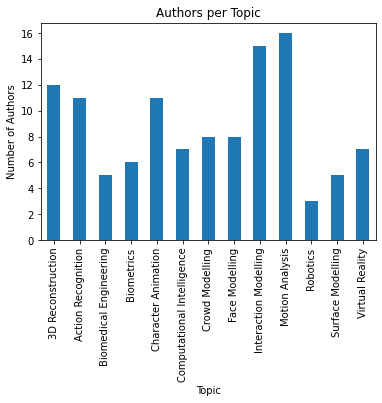

In [6]:
## Plotting the graph to visualise the authors in topic
author_topic = df7.groupby(['Topic'])['All Authors'].count() ## Group the columns topic and all authors and use count function
author_topic.plot(kind='bar') ## Plot the grouped data using bar plot

# set the title and labels
plt.title('Authors per Topic')
plt.xlabel('Topic')
plt.ylabel('Number of Authors')


plt.show() # Display the plot


Question 3B: Analyse the relationship between the features of the publication and the "citation" count. Suggest the top three features that have the highest impact on the "citation" count. Justify your answers with valid reasons.

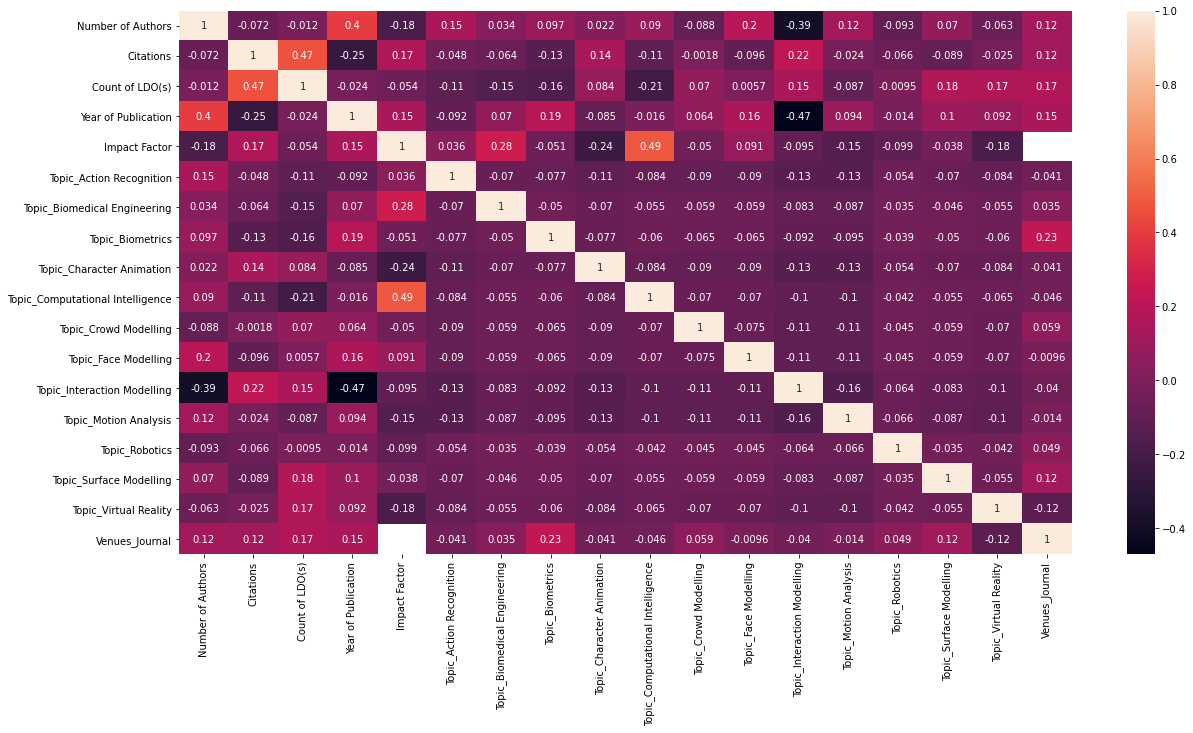

In [7]:
df8 = pd.get_dummies(df7, columns=['Topic', 'Venues'], drop_first=True) ## Use pd.get_dummies method is used to convert categorical variables into a set of numerical binary columns, also known as dummy variables
corr_matrix = df8.corr() # Calculate the correlation matrix

# Plot the heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(20, 10)) ## Set the size of the plot
sns.heatmap(corr_matrix, annot=True, ax=ax) ## Plot the heatmap to show correlation between the features
plt.show() ## Display the features

Question 3C: Each publication is published in a specific type of venue (such as “journal” or “conferernce”). You have to identify a specific feature "impact factor" for the publications and analyse its relationship with the type of venue where the article has been published.

In [8]:
df7[['Venues','Impact Factor']]

,Venues,Impact Factor
0,Conference,NaN
1,Conference,NaN
2,Journal,10.856
3,Conference,NaN
4,Journal,8.139
...,...,...
109,Journal,4.579
110,Conference,NaN
111,Conference,NaN
112,Journal,2.496
